In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback
from scipy.linalg import svd, inv, eig
from scipy.special import erf

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    OUTPUT_DIR = "./output/"
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running locally on beta.


In [2]:
import utils

In [78]:
run = utils.TrainingRun()
#P, model = run.load_state("../output/mlp_grokking-230411-124054")
P, model = run.load_state("../output/mlp_grokking-230412-092835")
#P, model = run.load_state("../output/mlp_grokking-230412-100753")
#P, model = run.load_state("../output/mlp_grokking-230413-073742")


In [18]:
def one_hot(i, n=113):
    v = np.zeros(n, dtype=np.float32)
    v[i] = 1.0
    return v

def abs_fft(x, axis=-1):
    return np.abs(np.fft.rfft(x, axis=axis))

In [6]:
def plot_matrix(m, ax):
    mmax = np.max(np.abs(m))
    ax.matshow(m, cmap="bwr", vmin=-mmax, vmax=mmax)
    ax.grid(False)

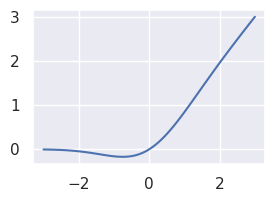

In [56]:
def gelu(x):
    return x / 2 * (1 + erf(x / np.sqrt(2)))

fig, ax = plt.subplots(1,1,figsize=(3,2))
x_range = np.linspace(-3,3,100)
ax.plot(x_range, gelu(x_range));

In [81]:
weights = model.get_weights()
print([ w.shape for w in weights ])

w_emb = weights[0]
w_mlp = weights[1].reshape(2,128,128)
w_uem = weights[2]

print(w_emb.shape, w_mlp.shape, w_uem.shape)

[(113, 128), (2, 128, 1, 128), (128, 113)]
(113, 128) (2, 128, 128) (128, 113)


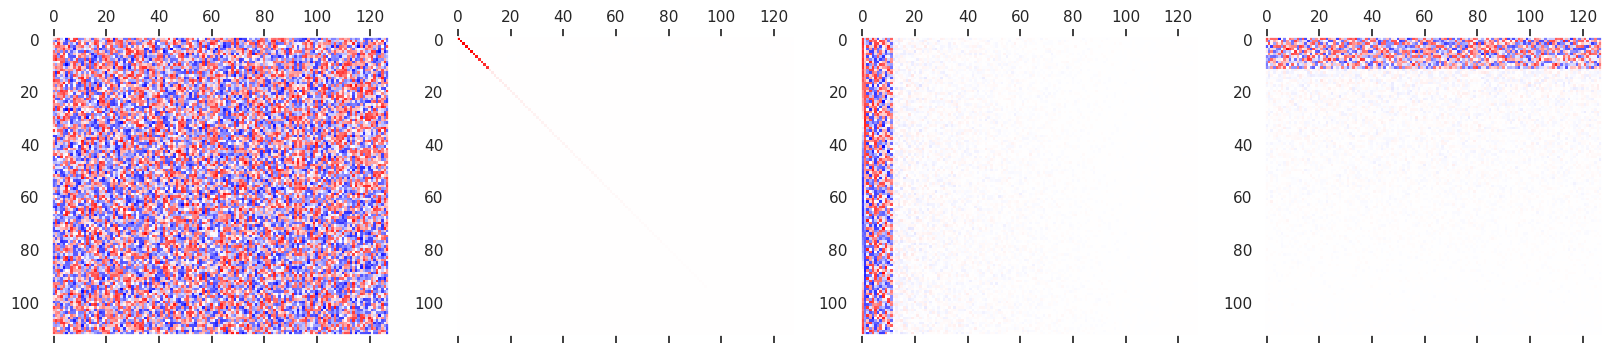

In [82]:
u_emb, s_emb, vt_emb = svd(w_emb)
w_emb_diag = u_emb.T @ w_emb @ vt_emb.T
#plt.matshow(w_emb_diag)
fig, axs = plt.subplots(1,4, figsize=(20,5))
plot_matrix(w_emb, axs[0])
plot_matrix(w_emb_diag, axs[1])
plot_matrix(u_emb @ w_emb_diag, axs[2])
plot_matrix(w_emb_diag @ vt_emb, axs[3]);

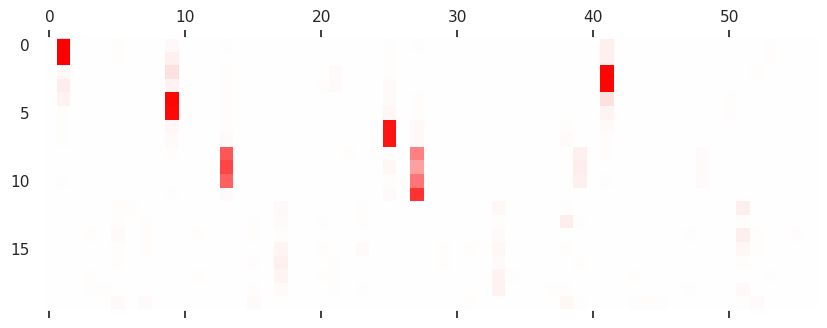

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
plot_matrix(abs_fft(u_emb @ w_emb_diag, axis=0)[:,:20].T, ax);

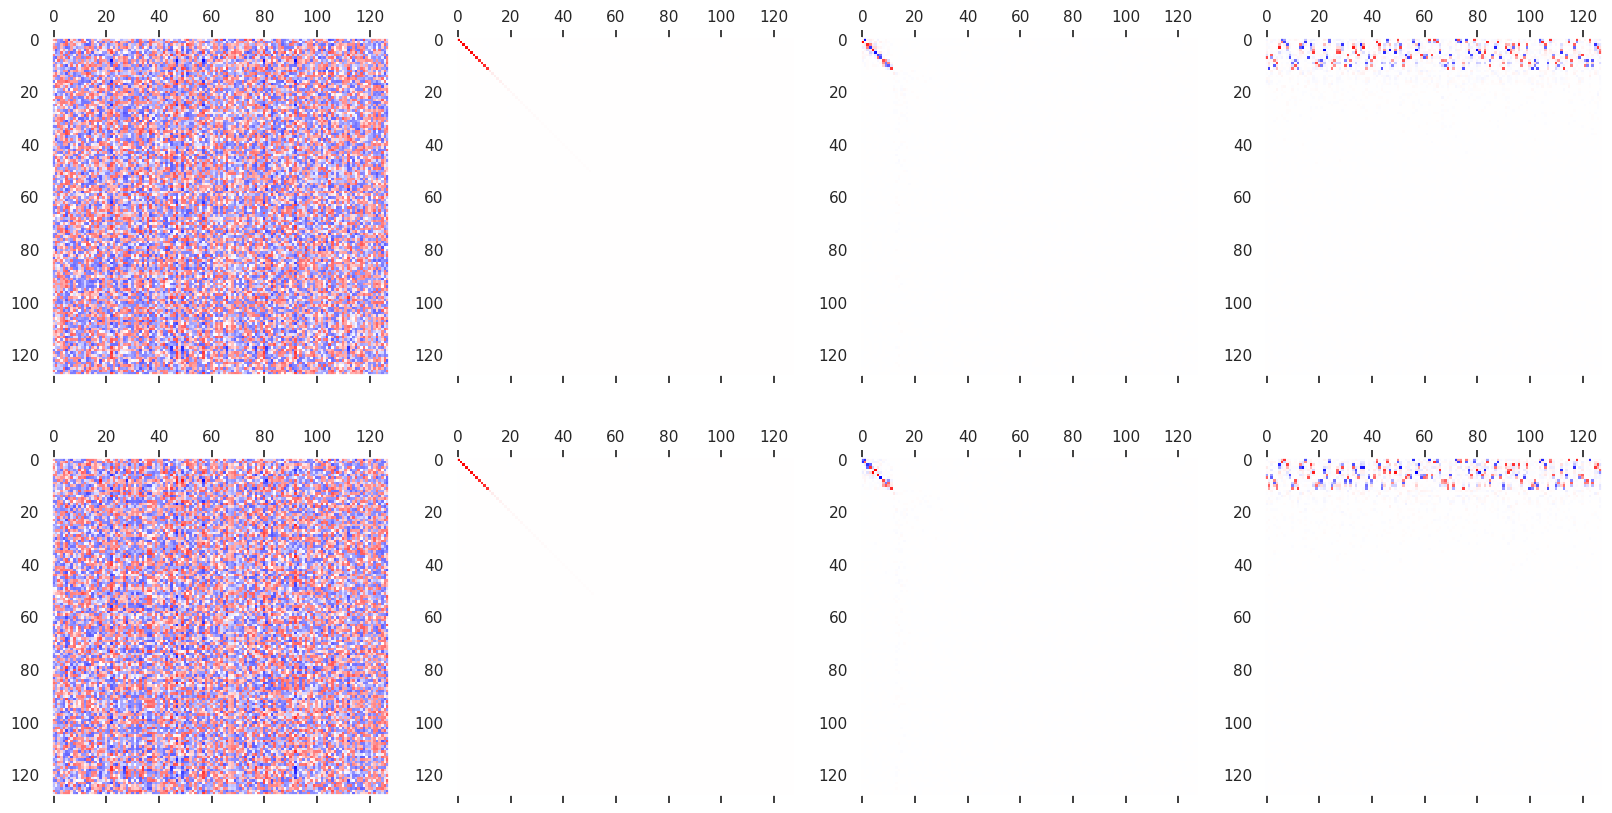

In [84]:
u_mlp, vt_mlp, s_mlp, w_mlp_diag = [None, None], [None, None], [None, None], [None, None]

fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(2):
    u_mlp[i], s_mlp[i], vt_mlp[i] = svd(w_mlp[i])
    w_mlp_diag[i] = u_mlp[i].T @ w_mlp[i] @ vt_mlp[i].T

    plot_matrix(w_mlp[i], axs[i,0])
    plot_matrix(w_mlp_diag[i], axs[i,1])
    plot_matrix(vt_emb @ u_mlp[i] @ w_mlp_diag[i], axs[i,2])
    plot_matrix(w_mlp_diag[i] @ vt_mlp[i], axs[i,3]);

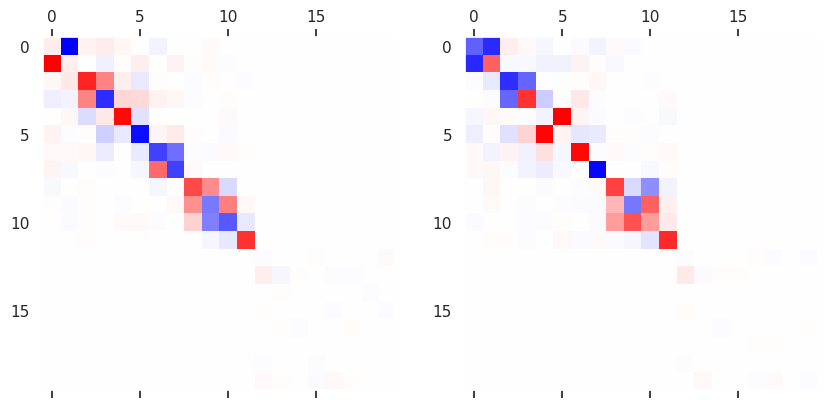

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

for i in range(2):
    plot_matrix((vt_emb @ u_mlp[i] @ w_mlp_diag[i])[:20,:20], axs[i])

In [113]:
(vt_emb @ u_mlp[1] @ w_mlp_diag[1])[:2,:2]

array([[-4.9253316, -6.6232324],
       [-6.660363 ,  4.888041 ]], dtype=float32)

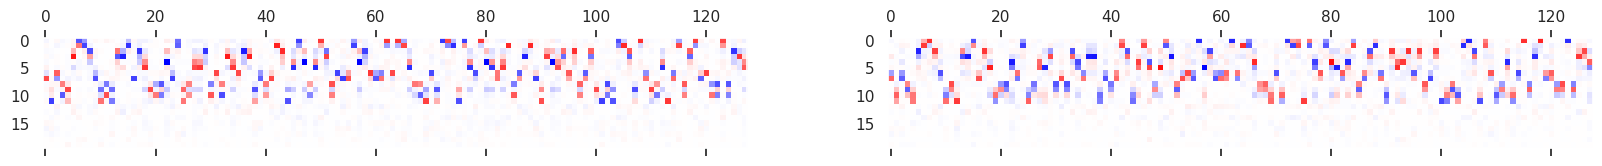

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

for i in range(2):
    plot_matrix((w_mlp_diag[i] @ vt_mlp[i])[:20], axs[i])

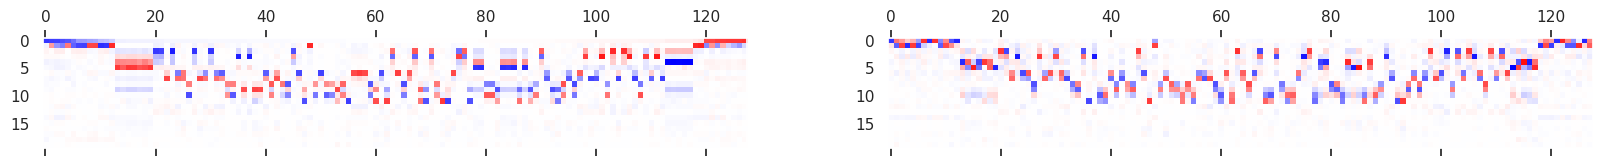

In [122]:
m0 = w_mlp_diag[0] @ vt_mlp[0]
m1 = w_mlp_diag[1] @ vt_mlp[1]

fig, axs = plt.subplots(1, 2, figsize=(20,5))
plot_matrix(m0[:,np.argsort(m0[0])][:20], axs[0])
plot_matrix(m1[:,np.argsort(m0[0])][:20], axs[1])


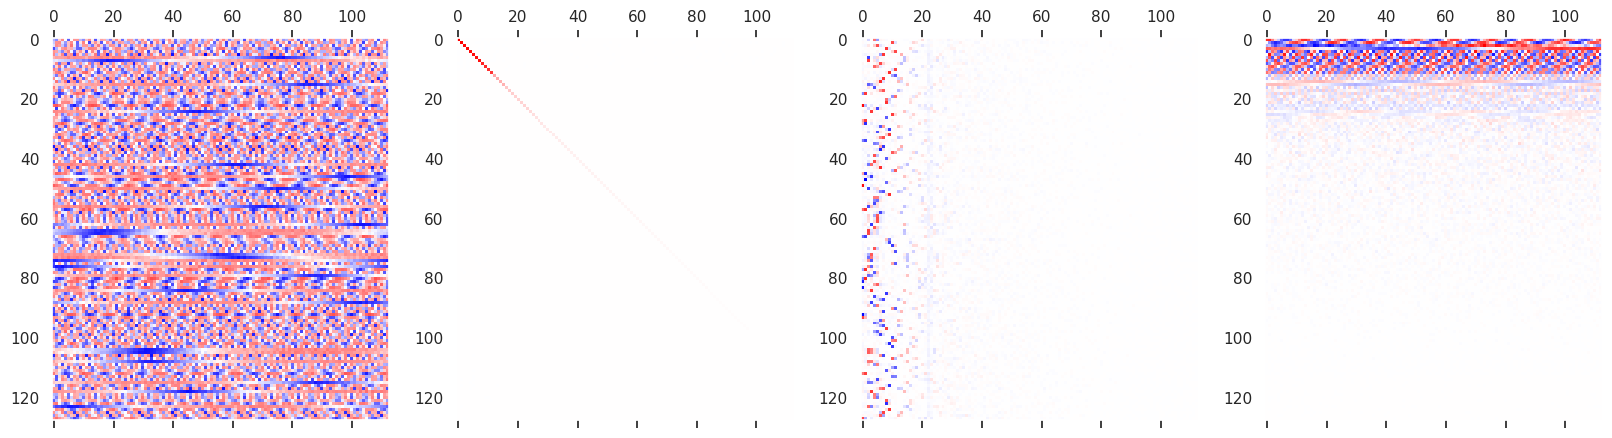

In [88]:
u_uem, s_uem, vt_uem = svd(w_uem)
w_uem_diag = u_uem.T @ w_uem @ vt_uem.T
fig, axs = plt.subplots(1,4, figsize=(20,5))
plot_matrix(w_uem, axs[0])
plot_matrix(w_uem_diag, axs[1])
plot_matrix(u_uem @ w_uem_diag, axs[2])
plot_matrix(w_uem_diag @ vt_uem, axs[3]);

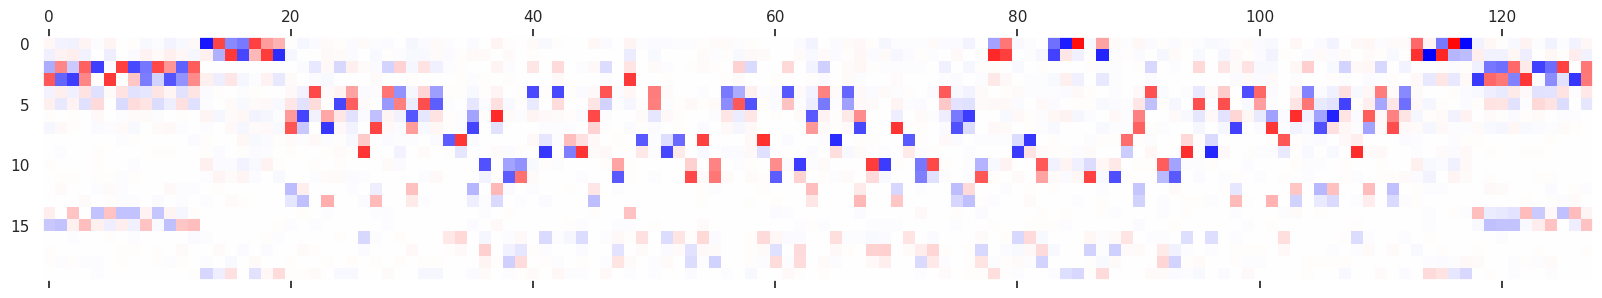

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))

plot_matrix((u_uem @ w_uem_diag)[np.argsort(m0[0]),:20].T, ax)

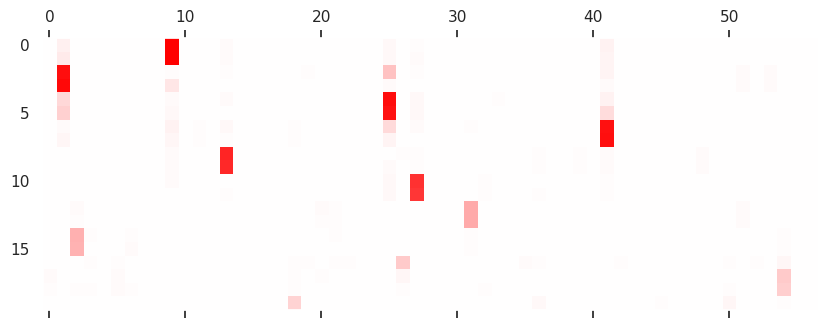

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
plot_matrix(abs_fft(w_uem_diag @ vt_uem, axis=1)[:20], ax);

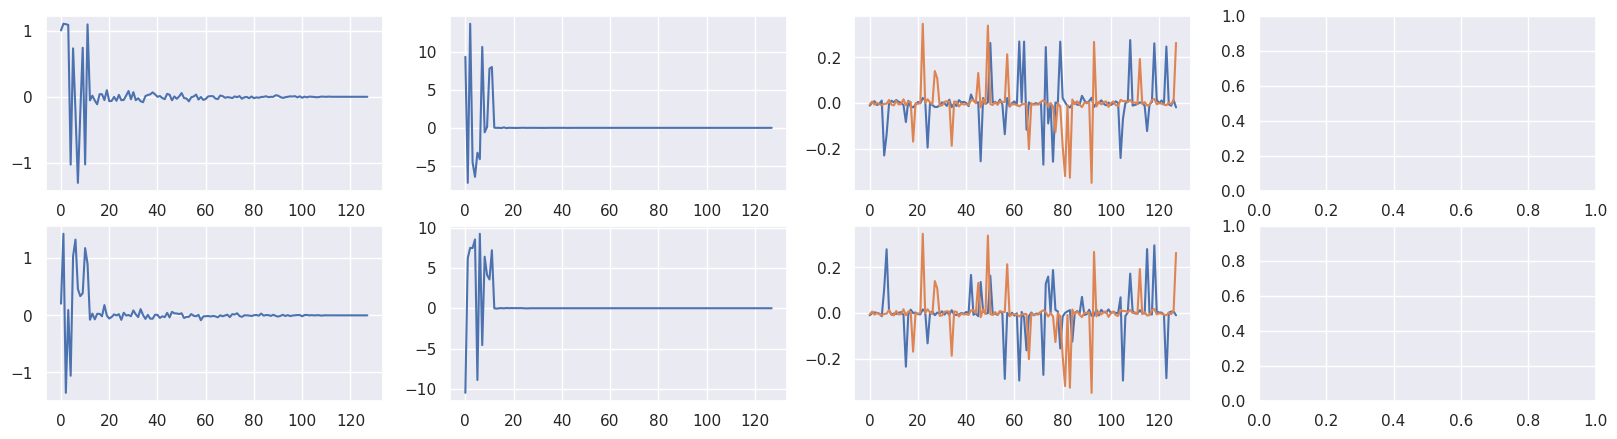

In [92]:
fig, axs = plt.subplots(2, 4, figsize=(20,5))

axs[0,0].plot(one_hot(17) @ u_emb @ w_emb_diag);
axs[1,0].plot(one_hot(29) @ u_emb @ w_emb_diag);

axs[0,1].plot(one_hot(17) @ u_emb @ w_emb_diag @ vt_emb @ u_mlp[0] @ w_mlp_diag[0]);
axs[1,1].plot(one_hot(29) @ u_emb @ w_emb_diag @ vt_emb @ u_mlp[1] @ w_mlp_diag[1]);

axs[0,2].plot(vt_mlp[0][0]);
axs[0,2].plot(u_uem[:,0]);
axs[1,2].plot(vt_mlp[1][0]);
axs[1,2].plot(u_uem[:,0]);

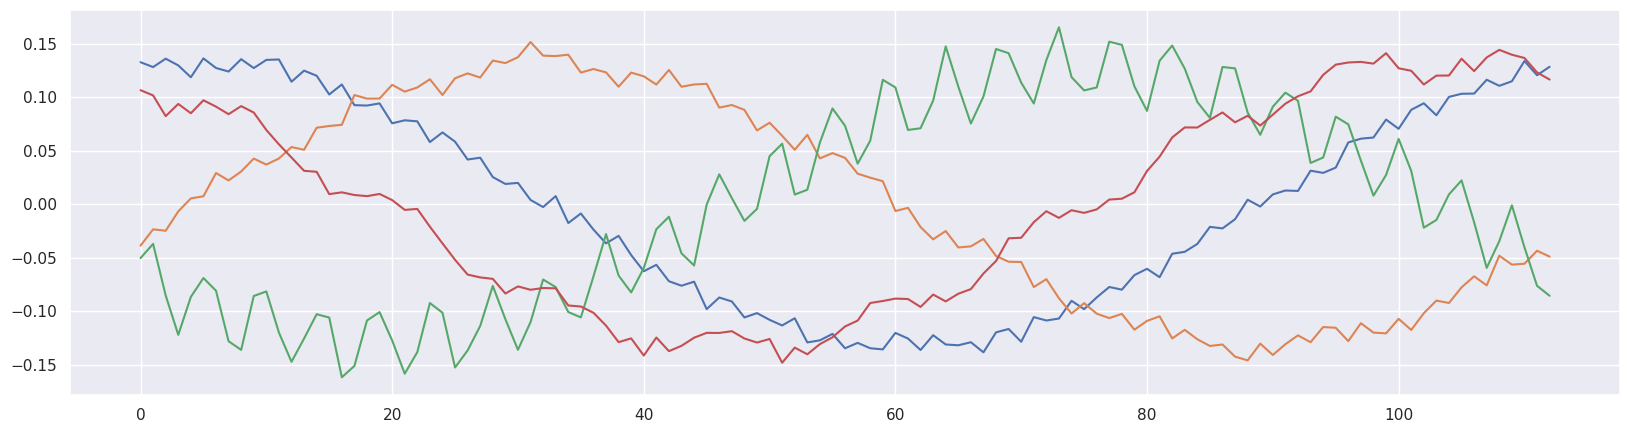

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))

ax.plot(u_emb[:,:2])
ax.plot(vt_uem[2:4].T)

In [68]:
x = np.array([-1, 1])
#x2 = np.array([-0.5, 0.5])

y1 = x @ (vt_emb @ u_mlp[0] @ w_mlp_diag[0] @ vt_mlp[0])[:2]
y2 = x @ (vt_emb @ u_mlp[1] @ w_mlp_diag[1] @ vt_mlp[1])[:2]
y = y1 + y2

y = gelu(y)

y = y @ u_uem[:,:2]
y.shape

(2,)

In [67]:
(vt_emb @ u_mlp[0] @ w_mlp_diag[0] @ vt_mlp[0])[:2].shape

(2, 128)

In [314]:
extractor = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])

In [315]:
ext_out = extractor.predict([[1,2]])
print([ o.shape for o in ext_out ])


1/1 [==============================] - 0s 102ms/step
[(1, 2), (1, 2, 128), (1, 2, 128, 1), (1, 1, 1, 128), (1, 1, 1, 128), (1, 128), (1, 113)]
